In [1]:
import pandas as pd
import sys

from pycaret.classification import *
from sklearn.metrics import average_precision_score

split_df=pd.read_csv('annotations.csv')

In [2]:
split_df['lag_word']=split_df.Word.shift(1)
split_df['new_sentence']=np.where(split_df.lag_word.isin(['.','?','!']),1,0)

In [4]:
target='label'
cat_fea=['pos','stop_word','new_sentence']
num_fea=['synt']+[x for x in split_df.columns if 'word_2vec_' in x or 'bert_' in x]
use_df=split_df[[target]+cat_fea+num_fea]

# add important features of neighbour words, to aggregate the contextual information
# this will increase the f1 score from ~0.85 to ~0.89
lag_feas=['synt','pos','word_2vec_71','bert_158','bert_718','word_2vec_40','bert_306','stop_word']
for col in lag_feas:
    use_df['prev_%s'%col]=use_df[col].shift(1)
    use_df['next_%s'%col]=use_df[col].shift(-1)   

# pyycaret sometimes raise an error for LGB if we feed the raw data to it
# so it will be better if we one hot it in advance and rename them
use_df=pd.concat((pd.get_dummies(use_df[['prev_pos','next_pos']]),
                  use_df[cat_fea+num_fea+[target]]),axis=1)

org_names=use_df.columns.tolist()
use_df.columns=['col_%s'%x for x in range(len(org_names))]
target='col_%s'%org_names.index(target) # find the label in our columns

use_df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,col_114,col_115,col_116,col_117,col_118,col_119,col_120,col_121,col_122,col_123,col_124,col_125,col_126,col_127,col_128,col_129,col_130,col_131,col_132,col_133,col_134,col_135,col_136,col_137,col_138,col_139,col_140,col_141,col_142,col_143,col_144,col_145,col_146,col_147,col_148,col_149,col_150,col_151,col_152,col_153,col_154,col_155,col_156,col_157,col_158,col_159,col_160,col_161,col_162,col_163,col_164,col_165,col_166,col_167,col_168,col_169,col_170,col_171,col_172,col_173,col_174,col_175,col_176,col_177,col_178,col_179,col_180,col_181,col_182,col_183,col_184,col_185,col_186,col_187,col_188,col_189,col_190,col_191,col_192,col_193,col_194,col_195,col_196,col_197,col_198,col_199,col_200,col_201,col_202,col_203,col_204,col_205,col_206,col_207,col_208,col_209,col_210,col_211,col_212,col_213,col_214,col_215,col_216,col_217,col_218,col_219,col_220,col_221,col_222,col_223,col_224,col_225,col_226,col_227,col_228,col_229,col_230,col_231,col_232,col_233,col_234,col_235,col_236,col_237,col_238,col_239,col_240,col_241,col_242,col_243,col_244,col_245,col_246,col_247,col_248,col_249,...,col_748,col_749,col_750,col_751,col_752,col_753,col_754,col_755,col_756,col_757,col_758,col_759,col_760,col_761,col_762,col_763,col_764,col_765,col_766,col_767,col_768,col_769,col_770,col_771,col_772,col_773,col_774,col_775,col_776,col_777,col_778,col_779,col_780,col_781,col_782,col_783,col_784,col_785,col_786,col_787,col_788,col_789,col_790,col_791,col_792,col_793,col_794,col_795,col_796,col_797,col_798,col_799,col_800,col_801,col_802,col_803,col_804,col_805,col_806,col_807,col_808,col_809,col_810,col_811,col_812,col_813,col_814,col_815,col_816,col_817,col_818,col_819,col_820,col_821,col_822,col_823,col_824,col_825,col_826,col_827,col_828,col_829,col_830,col_831,col_832,col_833,col_834,col_835,col_836,col_837,col_838,col_839,col_840,col_841,col_842,col_843,col_844,col_845,col_846,col_847,col_848,col_849,col_850,col_851,col_852,col_853,col_854,col_855,col_856,col_857,col_858,col_859,col_860,col_861,col_862,col_863,col_864,col_865,col_866,col_867,col_868,col_869,col_870,col_871,col_872,col_873,col_874,col_875,col_876,col_877,col_878,col_879,col_880,col_881,col_882,col_883,col_884,col_885,col_886,col_887,col_888,col_889,col_890,col_891,col_892,col_893,col_894,col_895,col_896,col_897,col_898,col_899,col_900,col_901,col_902,col_903,col_904,col_905,col_906,col_907,col_908,col_909,col_910,col_911,col_912,col_913,col_914,col_915,col_916,col_917,col_918,col_919,col_920,col_921,col_922,col_923,col_924,col_925,col_926,col_927,col_928,col_929,col_930,col_931,col_932,col_933,col_934,col_935,col_936,col_937,col_938,col_939,col_940,col_941,col_942,col_943,col_944,col_945,col_946,col_947,col_948,col_949,col_950,col_951,col_952,col_953,col_954,col_955,col_956,col_957,col_958,col_959,col_960,col_961,col_962,col_963,col_964,col_965,col_966,col_967,col_968,col_969,col_970,col_971,col_972,col_973,col_974,col_975,col_976,col_977,col_978,col_979,col_980,col_981,col_982,col_983,col_984,col_985,col_986,col_987,col_988,col_989,col_990,col_991,col_992,col_993,col_994,col_995,col_996,col_997
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [5]:
%%time
clf1 = setup(data = use_df,target = target,fold=10)
add_metric('apc', 'APC', average_precision_score, target = 'pred_proba') # add APC for this imbalanced data
best = compare_models(sort = 'f1',exclude = ['svm','knn','qda','nb'],n_select = 9) # return top 9 best models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9978,0.9875,0.8680,0.9211,0.8933,0.8922,0.8928,0.9209,50.8960
lr,Logistic Regression,0.9976,0.9791,0.8512,0.9124,0.8802,0.8790,0.8798,0.8928,29.2760
rf,Random Forest Classifier,0.9977,0.9826,0.8231,0.9461,0.8799,0.8787,0.8811,0.9290,108.1340
et,Extra Trees Classifier,0.9975,0.9798,0.8119,0.9409,0.8710,0.8698,0.8725,0.9171,33.5240
dt,Decision Tree Classifier,0.9972,0.9310,0.8638,0.8664,0.8645,0.8631,0.8634,0.7543,47.6100
gbc,Gradient Boosting Classifier,0.9969,0.9734,0.8554,0.8520,0.8532,0.8516,0.8519,0.7824,376.2440
ada,Ada Boost Classifier,0.9964,0.9785,0.7417,0.8940,0.8098,0.8080,0.8121,0.8768,72.5960
lda,Linear Discriminant Analysis,0.9961,0.9755,0.7656,0.8514,0.8039,0.8020,0.8043,0.8093,32.7270
ridge,Ridge Classifier,0.9956,0.0000,0.6153,0.9436,0.7439,0.7418,0.7596,0.0000,4.1440


Wall time: 2h 46min 1s


In [6]:
# return test f1 
for model in best:
    pred_holdout = predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Light Gradient Boosting Machine,0.9976,0.9824,0.8375,0.9306,0.8816,0.8803,0.8816,0.9014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Logistic Regression,0.9963,0.9765,0.7656,0.8781,0.8180,0.8162,0.8181,0.8862


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Random Forest Classifier,0.9973,0.9782,0.7812,0.9579,0.8606,0.8592,0.8638,0.9199


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Extra Trees Classifier,0.9971,0.9750,0.7906,0.9336,0.8562,0.8547,0.8577,0.9001


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Decision Tree Classifier,0.9968,0.9148,0.8312,0.8721,0.8512,0.8496,0.8499,0.7326


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Gradient Boosting Classifier,0.9966,0.9512,0.8156,0.8671,0.8406,0.8389,0.8393,0.8002


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Ada Boost Classifier,0.9958,0.9734,0.7125,0.8736,0.7849,0.7827,0.7869,0.8543


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Linear Discriminant Analysis,0.9958,0.9664,0.7219,0.8652,0.7871,0.7849,0.7882,0.7929


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC
0,Ridge Classifier,0.9949,0.7811,0.5625,0.9424,0.7045,0.7021,0.7260,0.5349


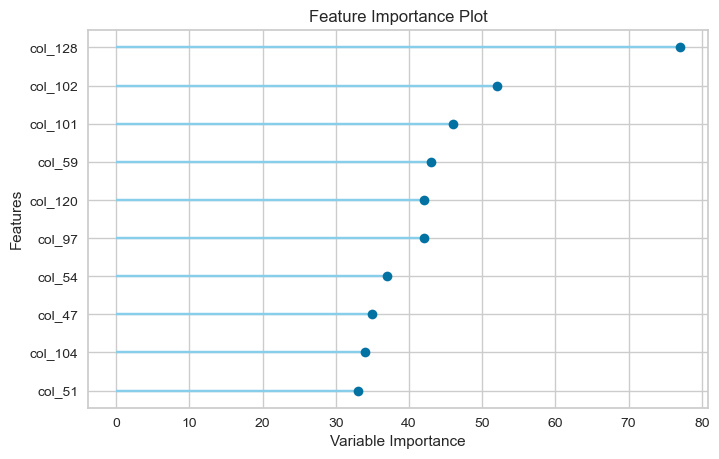

In [10]:
plot_model(best[0], plot = 'feature')

In [11]:
# get the most important features' name
cols=[128,102,101,59,120,97,54,47,104,51]
res=[]
for col in cols:
    res.append(['col_%s'%col,org_names[col]])
    
pd.DataFrame(res,columns=['column_name','original_name'])

,column_name,original_name
0,col_128,synt
1,col_102,next_pos_NNP
2,col_101,next_pos_NN
3,col_59,prev_pos_NN
4,col_120,next_pos_VBP
5,col_97,next_pos_JJ
6,col_54,prev_pos_IN
7,col_47,prev_pos_.
8,col_104,next_pos_NNS
9,col_51,prev_pos_DT
